# Assignment 3 Top-Level Code/Notebook
### Training a language model base on Karpathy's mingpt_1 codebase


In [29]:
# The code below is needed for using Google Colab, so un comment this if that is what you're using

import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
# The code below is also needed for using Google Colab
# BEFORE executing this, you must place the mingpt folder supplied in the assignment
# your google drive, within the folder "Colab Notebooks"
#
# It mounts and changes into the folder that contains mingpt, which you must upload to google drive
# So un-comment it if you've uploaded mingpt to your google drive, into the  "Colab Notebooks" folder

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


In [31]:
import torch 
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize 
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt_1.bpe import BPETokenizer 
from mingpt_1.utils import set_seed 
set_seed(1234)

In [32]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import datasets
#sst = datasets.load_dataset('glue', 'sst2')

In [34]:
sst_train = datasets.load_dataset('sst2', split='train')

In [35]:
sst_train[0]

{'idx': 0,
 'sentence': 'hide new secretions from the parental units ',
 'label': 0}

In [36]:
sst_train.to_csv('sst.csv')

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

4564251

In [37]:
df = pd.read_csv('sst.csv')
df = df.drop(['Unnamed: 0','idx'], axis = 1)

In [38]:
df1 = df[:1200]
sentence = df1['sentence']
label = df1['label']

In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
class ClassificationDataset(Dataset):
    def __init__(self, df, split="train", truncation=-1):
        
        self.df = df
        self.truncation = truncation  # int. If -1, then
    
        # Train / test split
        train, val = train_test_split(df1, test_size=0.2, stratify=df1['label'], random_state=0)
        if split == "train":
            raw_data = train['sentence']
        else:
            raw_data = val['sentence']
        self.y_train = train['label'].tolist()
        self.y_val = val['label'].tolist()
        self.split = split
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for sent in raw_data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
        but actually, only a small number of vocab is used, especially for the small text. 
        """
        return 50257

    def __getitem__(self, idx, ):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.data[idx]
        if self.split =='train':
          y = self.y_train[idx]
        else:
          y = self.y_val[idx]
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length
    
# Instantiate the Training Dataset
train_dataset = ClassificationDataset(df1, split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
val_dataset = ClassificationDataset(df1, split="validation", truncation=512)

In [41]:
# Print out an example of the data - this is processed more once it reaches lm_collate_fn (above)
x,y = train_dataset[111]
print(x, y)
print("X: ",train_dataset.tokenizer.decode(x))

tensor([   77,  3258,   876, 12883,   220]) 1
X:  narrative discipline 


In [42]:
def classify_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    y = torch.as_tensor(y).unsqueeze(1)
    maxlen = max([len(s) for s in x])

    padded_x = []
    for sx in x:
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
    return torch.stack(padded_x).long().to(device), y.to(device)

In [43]:
"""
Prepare the dataset to train the Language Model (LM)
This implementation splits the sentences and so doesn't create training 
examples that cross sentences.

This code is set so that it uses one of two possible datasets, which were also used in Assignment 1: 
SmallSimpleCorpus.txt or LargerCorpus.txt

Arguments:
            ds_choice: str. "small" or "large". (i.e. selects which of the two datasets)
            split: str. "train" or "test".
            truncation: int. If -1: no truncation on sentences. Otherwise: truncate to this specific length.
""" 

class LanguageModelingDataset(Dataset):
    
    def __init__(self, ds_choice="small", split="train", truncation=-1):
        
        base_path = "/content/"
        fn = {"small": "SmallSimpleCorpus.txt", "large": "LargerCorpus.txt"}
        self.ds_choice = ds_choice
        self.truncation = truncation 
        text = Path(base_path, fn[ds_choice]).read_text()
        if ds_choice == "large":
            # Remove the newline char in the middle of sentences
            # The "paragraph splitting" newlines appear to be \n\n -- remove the duplications there
            text = text.replace("\n\n", "$$^^$$").replace("\n", " ").replace("$$^^$$", "\n")
        sentences = sent_tokenize(text)

        # Train / test split
        train, val = train_test_split(sentences, test_size=0.2, shuffle=False)
        if split == "train":
            raw_data = train 
        else:
            raw_data = val 

        # Tokenize
        self.tokenizer = BPETokenizer()
        self.data = []  # List of 1-d pytorch tensor
        for sent in raw_data:
            tokenized = self.tokenizer(sent).view(-1)  # pytorch tensor
            if truncation >= 0:
                self.data.append(tokenized[:truncation])
            else:
                self.data.append(tokenized)

        # Count some items
        self.max_sentence_length = np.max([len(d) for d in self.data])

    def __len__(self):
        return len(self.data)

    def get_vocab_size(self):
        """
        We have to set this to the max vocab size (i.e., that decided by the BPE tokenizer), 
        but actually, only a small number of vocab is used, especially for the small text. 
        """
        return 50257

    def __getitem__(self, idx):
        """
        The output should be a tuple x and y, both as pytorch tensors.
        Please refer to the `run()` method in the mingpt/trainer.py script for 
        how the x and y are going to be used.
        """
        x = self.data[idx][:-1]
        y = self.data[idx][1:]
        print(self.max_sentence_length)
        return (x, y)

    def get_block_size(self):
        """
        block_size is the size at which lines are truncated to ensure they are equal-length.
        """
        return self.max_sentence_length
    
# Instantiate the Training Dataset
#train_dataset = LanguageModelingDataset(ds_choice="small", split="train")  # use this for the short corpus
lm_train_dataset = LanguageModelingDataset(ds_choice="large", split="train", truncation=512) #use this for long

# Instantiate a Validation Dataset (this is only really needed for the fine-tune task, not the LM task)
#val_dataset = LanguageModelingDataset(ds_choice="small", split="validation")
lm_val_dataset = LanguageModelingDataset(ds_choice="large", split="validation", truncation=512)

In [44]:
def lm_collate_fn(batch, device):
    x = [item[0] for item in batch]  # List (len B) of varying lengths
    y = [item[1] for item in batch]  # List (len B) of the same lengths as x
    maxlen = max([len(s) for s in x])

    padded_x, padded_y = [], []
    for sx, sy in zip(x, y):
        padded_x.append(torch.cat([sx, torch.ones(maxlen - len(sx))]))
        padded_y.append(torch.cat([sy, torch.ones(maxlen - len(sy))]))
    return torch.stack(padded_x).long().to(device), torch.stack(padded_y).long().to(device)


In [45]:
# bat = [train_dataset[10],train_dataset[11],train_dataset[12],train_dataset[13]]
# a,b = lm_collate_fn(bat)
# a,b
train_dataset[0]

(tensor([5143,  329, 3002,  220]), 0)

In [46]:
from mingpt_1.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = lm_train_dataset.get_vocab_size()
model_config.block_size = lm_train_dataset.get_block_size()
model_config.n_classification_class = 2
model = GPT(model_config)

number of parameters: 2.52M


In [47]:
model.load_state_dict(torch.load('/content/model_large1.pt'))

<All keys matched successfully>

In [48]:
# Create a Trainer object and set the core hyper-parameters
from mingpt_1.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 2000 # For small corpus: 3000 iterations is plenty. For large corpus: 100000 iterations is needed
train_config.num_workers = 0
train_config.batch_size = 4    # For small corpus, batch size of 4 is fine.  For large corpus use 16
trainer = Trainer(train_config, model, train_dataset, val_dataset, downstream_finetune=True , collate_fn=classify_collate_fn)

running on device cuda


In [49]:
y_train = df1['label'].tolist()
type(y_train)

list

In [50]:
# This function is called at the end of every batch in training
# and is used to report the amount of time per 100 batches, and the loss at that point

def batch_end_callback(trainer):
    print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}; train_acc {trainer.train_acc:.3f}; val loss {trainer.val_loss.item():.5f}; val_acc {trainer.val_acc:.3f}")
trainer.set_callback('on_batch_end', batch_end_callback)

# Train!
result = trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.71225; train_acc 0.007; val loss 0.30392; val_acc 0.007
iter_dt 16.54ms; iter 100: train loss 0.39602; train_acc 0.583; val loss 1.03114; val_acc 0.518
iter_dt 16.27ms; iter 200: train loss 0.60127; train_acc 0.613; val loss 0.67618; val_acc 0.575
iter_dt 16.22ms; iter 300: train loss 0.31064; train_acc 0.680; val loss 0.47326; val_acc 0.498
iter_dt 24.12ms; iter 400: train loss 0.00020; train_acc 0.767; val loss 5.89771; val_acc 0.580
iter_dt 19.40ms; iter 500: train loss 0.00141; train_acc 0.787; val loss 1.84465; val_acc 0.530
iter_dt 17.39ms; iter 600: train loss 0.00164; train_acc 0.868; val loss 0.46090; val_acc 0.595
iter_dt 24.04ms; iter 700: train loss 0.00048; train_acc 0.885; val loss 1.36888; val_acc 0.542
iter_dt 41.50ms; iter 800: train loss 0.15337; train_acc 0.880; val loss 0.29499; val_acc 0.553
iter_dt 15.77ms; iter 900: train loss 0.00163; train_acc 0.900; val loss 8.47672; val_acc 0.632
iter_dt 16.68ms; iter 1000: train loss 0.00

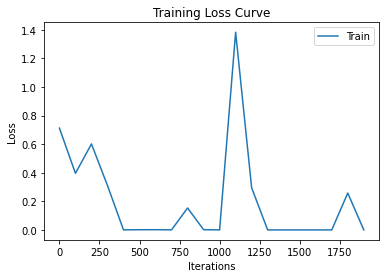

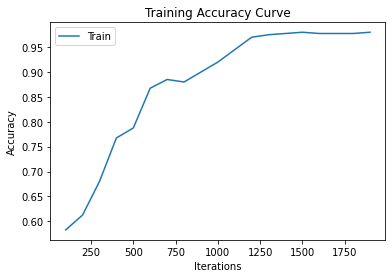

In [53]:
plt.title("Training Loss Curve")
plt.plot(result[0], result[2], label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Training Accuracy Curve")
plt.plot(result[0][1:], result[1][1:], label="Train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

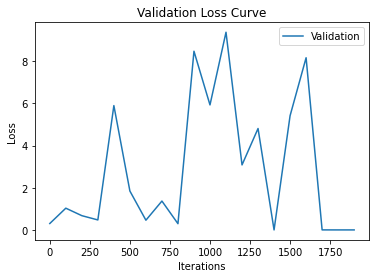

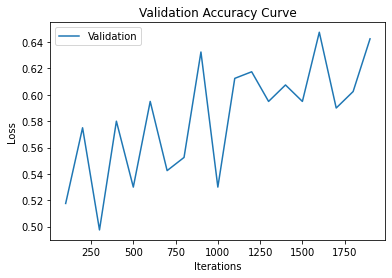

In [54]:
plt.title("Validation Loss Curve")
plt.plot(result[0], result[4], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.title("Validation Accuracy Curve")
plt.plot(result[0][1:], result[3][1:], label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()